In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, set_matplotlib_formats
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

set_matplotlib_formats('svg')
sns.set()
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [2]:
_clear = ['bingroup']

def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            if hasattr(trace, prop):
                trace.update({prop: None})

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = list(left.select_traces())
    t2 = list(right.select_traces())
    _clear_props([*t1, *t2])
    fig.add_traces(t1, rows=1, cols=1)
    fig.add_traces(t2, rows=1, cols=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

def to_plotly_text(text):
    return text.strip().replace('\n', '<br>')

(ch:mult_inference)=
# Inference for Multiple Linear Regression 

In linear regression, we fit a model of the following form:

$$
\begin{aligned}
f_\boldsymbol\theta (\textbf{x})
  &= \boldsymbol\theta \cdot \textbf{x} \\
  &= \theta_0 + \theta_1 x_1
    + \ldots + \theta_p x_p
\end{aligned}
$$

This model says that our prediction $f_\boldsymbol\theta (\textbf{x})$
depends linearly on each feature $x_i$.

Now, we'd like to generalize the model from the sample
to the population.
The key idea is to treat our data as random draws from the population.
Then, we can use bootstrap resampling to simulate drawing multiple samples.
We'll fit the model on each resample, make confidence intervals for 
the model parameters, and use the confidence intervals to make inferences
about the population.
Let's see this process through an example.

## The Data

Otis Dudley Duncan was a quantitative sociologist interested in measuring the prestige levels of different occupations. There were only 90 occupations that were rated for their prestige level in the 1947 National Opinion Research Center (NORC) survey. Duncan wanted to “fill in” prestige scores for unrated occupations by using income and education data about each occupation recorded by the 1950 census. When joining the NORC data with the 1950 census data, only 45 occupations could be matched. Ultimately, Duncan's goal was to create a model to explain prestige using different characteristics; using this model, one can predict the prestige of other occupations not recorded in the NORC survey.

The Duncan dataset is a random sample of that contains information on the prestige and other characteristics of 45 U. S. occupations in 1950. 
The variables are:

`occupation` represents the type of occupation/title.

`income` represents the percentage of occupational incumbents who earned incomes in excess of $3,500.

`education` represents the percentage of incumbents in the occupation in the 1950 U.S. Census who were high school graduates.

`prestige` represents the percentage of respondents in a survey who rated an occupation as “good” or “excellent” in prestige.






In [5]:
duncan = pd.read_csv('data/duncan.csv').loc[:, ["occupation", "income", "education", "prestige"]]
duncan

,occupation,income,education,prestige
0,accountant,62,86,82
1,pilot,72,76,83
2,architect,75,92,90
...,...,...,...,...
42,janitor,7,20,8
43,policeman,34,47,41
44,waiter,8,32,10


It's a good idea to explore the data through visualization in order to gain an understanding of the relationships between our variables.
To see if we can use income and education to predict prestige, we'll
create scatter plots that show the relation between these variables and
prestige.

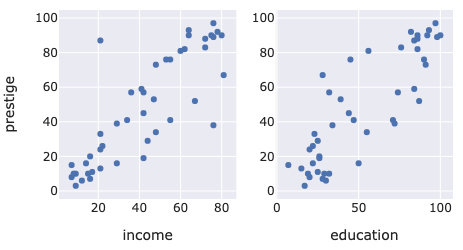

In [15]:
f1 = px.scatter(duncan, x='income', y='prestige')
f2 = px.scatter(duncan, x='education', y='prestige')

fig = left_right(f1, f2)
fig.update_xaxes(title='income', row=1, col=1)
fig.update_yaxes(title='prestige', row=1, col=1)
fig.update_xaxes(title='education', row=1, col=2)

From the plots above, we see that both education and income are positively correlated with prestige; hence, both of these variables might be useful in helping explain prestige. Let's fit a linear model using these explanatory variables to explain prestige.

## Fitting the model 

We will fit the following model, that explains the prestige of an occupation as a linear function of income and education:

$$
\begin{aligned}
\texttt{prestige}_i
= \theta_0 
+ \theta_\texttt{income}\cdot\texttt{income}_i
+ \theta_\texttt{education}\cdot\texttt{education}_i
\end{aligned}
$$

In order to fit this model, we will define the design matrix (X) and our response variable (y):

In [16]:
X = duncan.loc[:, ["income", "education"]]
X.head()

,income,education
0,62,86
1,72,76
2,75,92
3,55,90
4,64,86


In [17]:
y = duncan.loc[:, "prestige"]
y.head()

0    82
1    83
2    90
3    76
4    90
Name: prestige, dtype: int64

Below, we fit our linear model and print all the $\hat{\theta}$ coefficients of the model (from the equation above) after the model has been fit to the data. Note that these are our sample coefficients.

In [23]:
import sklearn.linear_model as lm

model = lm.LinearRegression()
model.fit(X, y)

intercept = model.intercept_
income, education = model.coef_

print(f"""
intercept:    {intercept:.2f}
income:       {income:.2f}
education:    {education:.2f}
""")


intercept:    -6.06
income:       0.60
education:    0.55



The coefficients above give us an estimate of the true coefficients. But had our sample data been different, we would have fit our model to different data, causing these coefficients to be different. We would like to explore what our coefficients might have been using bootstrapping methods.

In our bootstrapping methods and analysis, we will focus on the coefficient of education. We would like to explore the partial relationship between prestige and education holding income constant (rather than the marginal relationship between prestige and education ignoring income). The partial regression coefficient $\widehat\theta_\texttt{education}$ illustrates the partial relationship between prestige and education within our data. 

## Bootstrapping the Observations 

In this method, we consider the pairs $(X_i, y_i)$ to be our sample, so we construct the bootstrap resample by sampling with replacement from these pairs:

$$
\begin{aligned}
(X_i^*, y_i^*) 
= (X_I, y_I), \text{ where } I=1,\dots,n \text{ is sampled uniformly at random.}
\end{aligned}
$$

In other words, we sample n observations with replacement from our data points; this is our bootstrap sample. Then we will fit a new linear regression model to this sampled data and record the education coefficient $\tilde\theta_\texttt{education}$; this coefficient is our bootstrap statistic.

In [24]:
def simple_resample(n): 
    return np.random.randint(low=0, high=n, size=n)

def bootstrap(boot_pop, statistic, resample=simple_resample, replicates=10000):
    n = len(boot_pop)
    resample_estimates = [statistic(boot_pop[resample(n)])
                          for _ in range(replicates)]
    return np.array(resample_estimates)

In [25]:
def educ_coeff(data_array):
    X = data_array[:, 1:]
    y = data_array[:, 0]
    
    linear_model = lm.LinearRegression()
    model = linear_model.fit(X, y)
    theta_educ = model.coef_[1]

    return theta_educ

data_array = duncan.loc[:, ["prestige", "income", "education"]].values

theta_hat_sampling = bootstrap(data_array, educ_coeff)

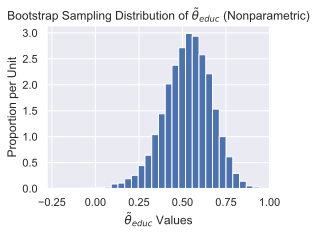

In [45]:
plt.figure(figsize = (4, 3))
plt.hist(theta_hat_sampling, bins=30, density=True)
plt.xlabel("$\\tilde{\\theta}_{educ}$ Values")
plt.ylabel("Proportion per Unit")
plt.title("Bootstrap Sampling Distribution of $\\tilde{\\theta}_{educ}$ (Nonparametric)");
plt.show()

Notice how the sampling distribution above is slightly skewed to the left. 

### Estimating the True Coefficients

Although we cannot directly measure $\theta^*_\texttt{education}$ we can use a bootstrap confidence interval to account for variability in the sample regression coefficient $\widehat\theta_{\texttt{education}}$. Below, We construct an approximate 95% confidence interval for the true coefficient $\theta^*_\texttt{education}$, using the bootstrap percentile method. The confidence interval extends from the 2.5th percentile to the 97.5th percentile of the 10,000 bootstrapped coefficients.

In [46]:
left_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 2.5)
right_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 97.5)

left_confidence_interval_endpoint, right_confidence_interval_endpoint

(0.2349176380021313, 0.7795582405415913)

From the confidence interval above, we estimate that the true coefficient lies between 0.236 and 0.775.

### Could the true coefficient be 0?

Although we observed a positive partial relationship between education and prestige (from the 0.55 coefficient), what if the true coefficient is actually 0 and there is no partial relationship between education and prestige? In this case, the association that we observed was just due to variability in obtaining the points that form our sample.

To formally test whether the partial relationship between education and prestige is real, we would like to test the following hypotheses:

**Null Hypothesis:** The true partial coefficient is 0.

**Alternative Hypothesis.** The true partial coefficient is not 0.

Since we have already contructed a 95% confidence interval for the true coefficient, we just need to see whether 0 lies within this interval. Notice that 0 does not lie within our confidence interval above; therefore, we have enough evidence to reject the null hypothesis.  

If the confidence interval for the true coefficient did contain 0, then we would not have enough evidence to reject the null hypothesis.

### Checking for Collinearity

Before taking confidence intervals at face value, it's also important to check
for collinearity---when
two (or more) variables are highly correlated with each other.
Collinearity can make it seem like variables are not significantly related to
the response even if they are.
Let's see a short example.
For the data below, we'll use traits of bird eggs to predict the
newborn chick weight.

In [98]:
eggs = pd.read_csv('data/snowy_plover.csv')
eggs

,egg_weight,egg_length,egg_breadth,bird_weight
0,7.4,28.80,21.84,5.2
1,7.7,29.04,22.45,5.4
2,7.9,29.36,22.48,5.6
...,...,...,...,...
41,9.1,33.15,23.02,6.6
42,9.9,33.30,23.70,7.1
43,9.0,33.73,22.72,6.3


But when we make confidence intervals for the model coefficients, we find 
something strange.
All of the confidence intervals contain 0, which prevents us from concluding
that *any* variable is significantly related to the response. 

In [106]:
def egg_thetas(data):
    X = data[:, :3]
    y = data[:, 3]
    
    model = lm.LinearRegression().fit(X, y)
    return model.coef_

egg_thetas = bootstrap(eggs.values, egg_thetas)

In [108]:
egg_ci = np.percentile(egg_thetas, [2.5, 97.5], axis=0)
pd.DataFrame(egg_ci.T,
             columns=['lower', 'upper'],
             index=['theta_egg_weight', 'theta_egg_length', 'theta_egg_breadth'])

,lower,upper
theta_egg_weight,-0.26,1.10
theta_egg_length,-0.10,0.21
theta_egg_breadth,-0.26,0.76


To see what's going on, we'll make a scatter plot matrix for the data.

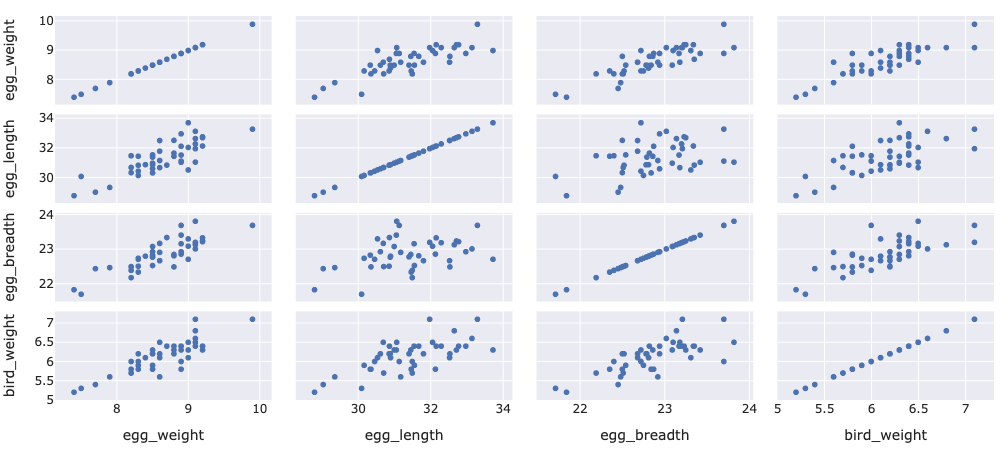

In [110]:
px.scatter_matrix(eggs, width=450, height=450)

This shows that `bird_weight`
is highly correlated with all the other
variables (the bottom row), which means fitting a linear model is a good idea.
But we also see that `egg_weight` is highly correlated with all the variables
(the top row).
This means we can't increase one covariate while
keeping the others constant. The individual slopes have no meaning.

One way to fix this is to fit a model that only uses `egg_weight`.
This model performs almost as well as the model that uses all three variables,
and the confidence interval for $\theta^*_{\texttt{egg_weight}}$ doesn't 
contain zero.

In [111]:
def only_egg_weight(data):
    X = data[:, :1]
    y = data[:, 3]
    
    model = lm.LinearRegression().fit(X, y)
    return model.coef_

egg_weight_thetas = bootstrap(eggs.values, only_egg_weight)

In [117]:
pd.DataFrame(
    np.percentile(egg_weight_thetas, [2.5, 97.5], axis=0).T,
    index=['theta_egg_weight'],
    columns=['lower', 'upper'],
)

,lower,upper
theta_egg_weight,0.6,0.82


It's no surprise that if you want to predict the
weight of the newly-hatched chick, using the weight
of the egg is your best move.

As this example shows, checking for collinearity is important for inference.
When we fit a model on highly correlated variables, we might not be able to
use confidence intervals to conclude that variables are
related to the prediction.

In this section, we saw how to use the bootstrap to perform inference
for multivariate linear models.
We can use bootstrap resampling to create confidence intervals for model
coefficients, which then lets us make conclusions about the population.
And, we saw how collinearity can prevent us from seeing what 
variables are important for the model. 

This section also illustrates a key tradeoff in data science: the tradeoff
between using models for inference or prediction.
When we want to fit a model that we can readily use for inference, we 
remove highly correlated variables so that confidence intervals can show
the importance of each variable.
But this can mean sacrificing some predictive accuracy, since we have fewer
variables to use to make predictions.
Before we fit models, we should first understand what our modeling goals are.